In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import joblib

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

In [5]:
# === Data Loading ===
# Load the Telco Customer Churn dataset (replace with your file path)
df = pd.read_csv('Customer-Churn.csv')
print("=== Data Overview ===")
print("Shape:", df.shape)
print("\nInfo:")
print(df.info())
print("\nFirst 5 Rows:")
print(df.head())

=== Data Overview ===
Shape: (7043, 21)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 


In [6]:
# === Data Cleaning ===
print("\n=== Data Cleaning ===")
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())


=== Data Cleaning ===
Missing Values:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [7]:
# Convert 'TotalCharges' to numeric, handle non-numeric values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

C:\Users\MSI\AppData\Local\Temp\ipykernel_19668\3744015957.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


In [8]:
# Remove duplicates
initial_shape = df.shape
df.drop_duplicates(inplace=True)
print(f"Shape after removing duplicates: {df.shape} (Removed {initial_shape[0] - df.shape[0]} duplicates)")

Shape after removing duplicates: (7043, 21) (Removed 0 duplicates)


In [9]:
# Convert data types
df['SeniorCitizen'] = df['SeniorCitizen'].astype('category')
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0}).astype(int)


=== Exploratory Data Analysis ===


C:\Users\MSI\AppData\Local\Temp\ipykernel_19668\408250610.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=df, palette='Set2')


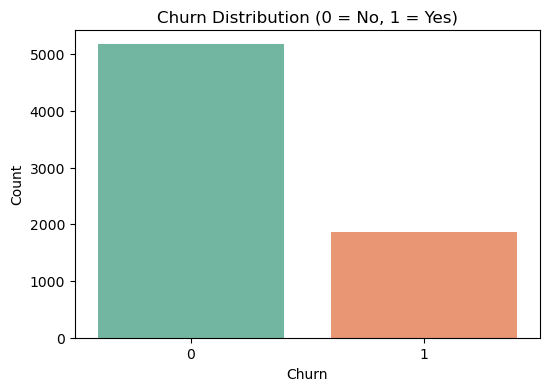

Churn Distribution (Proportions):
Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64


In [10]:
# === Exploratory Data Analysis (EDA) ===
print("\n=== Exploratory Data Analysis ===")
# Churn distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df, palette='Set2')
plt.title('Churn Distribution (0 = No, 1 = Yes)')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.savefig('churn_distribution.png')
plt.show()
print("Churn Distribution (Proportions):")
print(df['Churn'].value_counts(normalize=True))

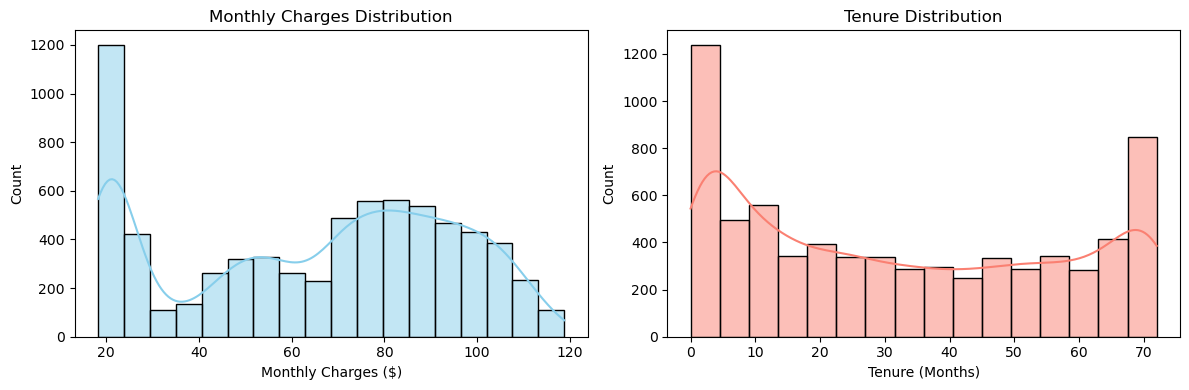

In [11]:
# Numerical feature distributions
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(df['MonthlyCharges'], kde=True, color='skyblue')
plt.title('Monthly Charges Distribution')
plt.xlabel('Monthly Charges ($)')
plt.subplot(1, 2, 2)
sns.histplot(df['tenure'], kde=True, color='salmon')
plt.title('Tenure Distribution')
plt.xlabel('Tenure (Months)')
plt.tight_layout()
plt.savefig('numerical_distributions.png')
plt.show()

C:\Users\MSI\AppData\Local\Temp\ipykernel_19668\1973771700.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='MonthlyCharges', data=df, palette='Set2')


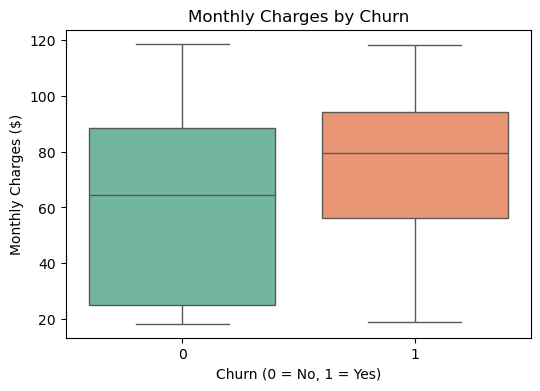

In [12]:
# Boxplot: MonthlyCharges by Churn
plt.figure(figsize=(6, 4))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df, palette='Set2')
plt.title('Monthly Charges by Churn')
plt.xlabel('Churn (0 = No, 1 = Yes)')
plt.ylabel('Monthly Charges ($)')
plt.savefig('monthly_charges_by_churn.png')
plt.show()

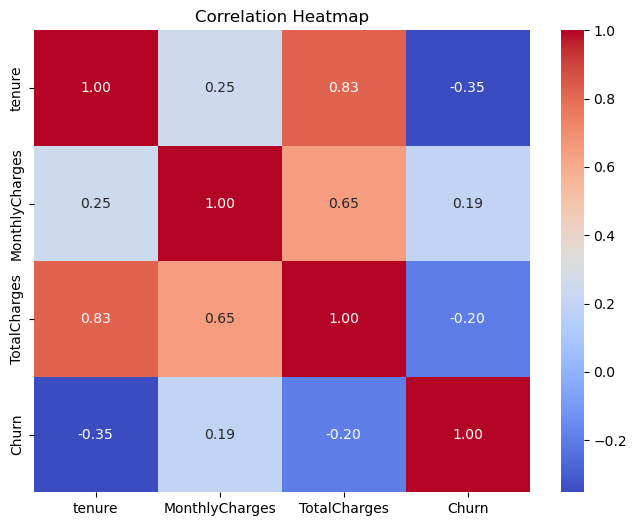

In [13]:
# Correlation heatmap
plt.figure(figsize=(8, 6))
corr_matrix = df[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.savefig('correlation_heatmap.png')
plt.show()

In [14]:
# === Feature Engineering ===
print("\n=== Feature Engineering ===")
# One-hot encoding for categorical features
categorical_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                      'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                      'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                      'PaperlessBilling', 'PaymentMethod']
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)


=== Feature Engineering ===


In [15]:
# Create new features
df_encoded['tenure_category'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 72, float('inf')],
                                      labels=['0-1yr', '1-2yr', '2-4yr', '4-6yr', '6+yr'])
df_encoded['charge_per_month'] = df_encoded['TotalCharges'] / (df_encoded['tenure'] + 1)
df_encoded = pd.get_dummies(df_encoded, columns=['tenure_category'], drop_first=True)

In [17]:
# Save engineered dataset
df_encoded.to_csv('engineered_telco_churn.csv', index=False)
print("Engineered dataset saved as 'engineered_telco_churn.csv'")

Engineered dataset saved as 'engineered_telco_churn.csv'


In [18]:
# === Model Training ===
print("\n=== Model Training ===")
# Split data
X = df_encoded.drop(columns=['Churn', 'customerID'])
y = df_encoded['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


=== Model Training ===


In [19]:
# Scale numerical features
scaler = StandardScaler()
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'charge_per_month']
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [21]:
#Initialize models (expanded set)
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

In [22]:
# Train and evaluate models
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test)
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='f1')
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob),
        'CV F1 Mean': cv_scores.mean()
    })
    print(f"\n{name} Performance:")
    print(f"Accuracy: {results[-1]['Accuracy']:.2f}")
    print(f"Precision: {results[-1]['Precision']:.2f}")
    print(f"Recall: {results[-1]['Recall']:.2f}")
    print(f"F1-Score: {results[-1]['F1-Score']:.2f}")
    print(f"ROC AUC: {results[-1]['ROC AUC']:.2f}")
    print(f"Cross-Validation F1: {cv_scores.mean():.2f}")

C:\Users\MSI\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\MSI\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = 


Logistic Regression Performance:
Accuracy: 0.80
Precision: 0.67
Recall: 0.52
F1-Score: 0.59
ROC AUC: 0.85
Cross-Validation F1: 0.59

Random Forest Performance:
Accuracy: 0.80
Precision: 0.66
Recall: 0.52
F1-Score: 0.58
ROC AUC: 0.84
Cross-Validation F1: 0.57

Gradient Boosting Performance:
Accuracy: 0.80
Precision: 0.65
Recall: 0.51
F1-Score: 0.57
ROC AUC: 0.84
Cross-Validation F1: 0.59

SVM Performance:
Accuracy: 0.79
Precision: 0.66
Recall: 0.47
F1-Score: 0.55
ROC AUC: 0.80
Cross-Validation F1: 0.00


In [23]:
# Model comparison
print("\nModel Comparison:")
results_df = pd.DataFrame(results)
print(results_df)


Model Comparison:
                 Model  Accuracy  Precision    Recall  F1-Score   ROC AUC  \
0  Logistic Regression  0.804116   0.666667  0.524064  0.586826  0.846720   
1        Random Forest  0.799858   0.656463  0.516043  0.577844  0.842963   
2    Gradient Boosting  0.797019   0.648649  0.513369  0.573134  0.843057   
3                  SVM  0.794180   0.659091  0.465241  0.545455  0.798450   

   CV F1 Mean  
0    0.591211  
1    0.573853  
2    0.585646  
3    0.000000  


In [24]:
# Select best model based on F1-score (or ROC AUC for balance)
best_model_name = results_df.loc[results_df['F1-Score'].idxmax(), 'Model']
print(f"\nBest Model: {best_model_name}")


Best Model: Logistic Regression


In [26]:
# Train best model (Gradient Boosting or Random Forest likely to perform best)
best_model = models[best_model_name]
best_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)


=== Feature Importance ===

Top 10 Features by Importance (Logistic Regression - Coefficient Magnitudes):
charge_per_month               1.699338
Contract_Two year              1.538100
InternetService_Fiber optic    1.411528
tenure                         0.948615
Contract_One year              0.734844
StreamingMovies_Yes            0.510223
StreamingTV_Yes                0.508985
MultipleLines_Yes              0.494012
PaperlessBilling_Yes           0.373878
PhoneService_Yes               0.358279
dtype: float64


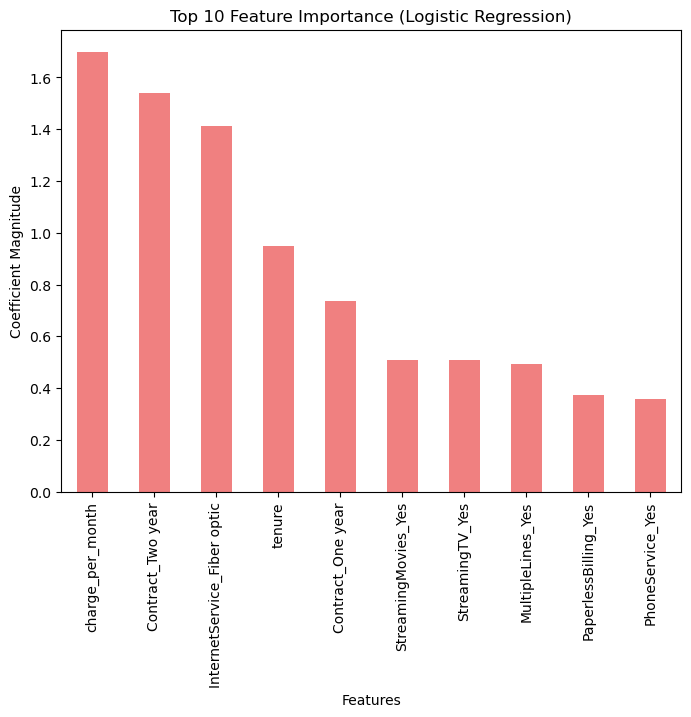

In [39]:
# Feature importance
print("\n=== Feature Importance ===")

# Dictionary to store feature importance for all models
feature_importances = {}

# Logistic Regression: use coefficient magnitudes
if best_model_name == 'Logistic Regression':
    feature_importance = pd.Series(np.abs(best_model.coef_[0]), index=X.columns).sort_values(ascending=False)
    feature_importances['Logistic Regression'] = feature_importance
    print("\nTop 10 Features by Importance (Logistic Regression - Coefficient Magnitudes):")
    print(feature_importance.head(10))
    
    # Visualize feature importance
    plt.figure(figsize=(8, 6))
    feature_importance.head(10).plot(kind='bar', color='lightcoral')
    plt.title('Top 10 Feature Importance (Logistic Regression)')
    plt.xlabel('Features')
    plt.ylabel('Coefficient Magnitude')
    plt.savefig('feature_importance_logreg.png')
    plt.show()


=== Predicted Probabilities for Churn ===

Top 5 Customers Most Likely to Churn:
      CustomerID  Predicted_Churn  Churn_Probability
1090        3380                1           0.943929
1221        6866                1           0.931964
1109        4585                1           0.914219
51          2246                1           0.902846
278         2397                1           0.901079


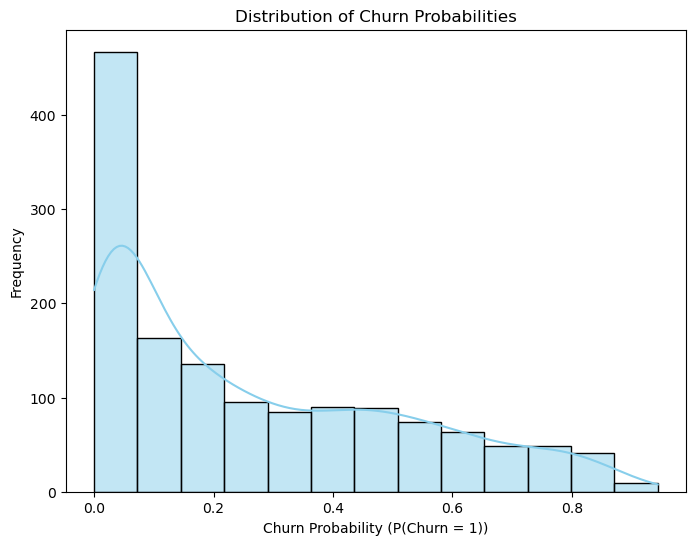

In [44]:
# Predict probabilities for test set
print("\n=== Predicted Probabilities for Churn ===")
y_prob = best_model.predict_proba(X_test)[:, 1]  # Probability of Churn = 1
y_pred = (y_prob >= 0.5).astype(int)  # Classify using threshold 0.5

# Create a DataFrame with predictions and probabilities
results_df = pd.DataFrame({
    'CustomerID': X_test.index,  
    'Predicted_Churn': y_pred,
    'Churn_Probability': y_prob
})

# Show top 5 high-risk customers (highest churn probability)
print("\nTop 5 Customers Most Likely to Churn:")
print(results_df.sort_values(by='Churn_Probability', ascending=False).head(5))

# Show distribution of churn probabilities
plt.figure(figsize=(8, 6))
sns.histplot(y_prob, kde=True, color='skyblue')
plt.title('Distribution of Churn Probabilities')
plt.xlabel('Churn Probability (P(Churn = 1))')
plt.ylabel('Frequency')
plt.savefig('churn_probability_distribution.png')
plt.show()

In [40]:
# === Model Evaluation ===
print("\n=== Model Evaluation ===")
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, 'predict_proba') else best_model.decision_function(X_test)


=== Model Evaluation ===


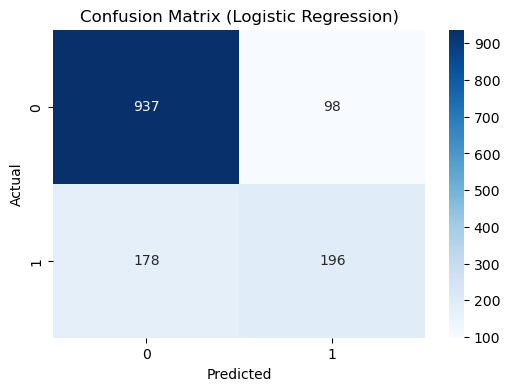

In [41]:
# Confusion matrix
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix ({best_model_name})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix.png')
plt.show()

In [42]:
# Final performance metrics
print(f"\nFinal Model Performance ({best_model_name}):")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_pred):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.2f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.2f}")


Final Model Performance (Logistic Regression):
Accuracy: 0.80
Precision: 0.67
Recall: 0.52
F1-Score: 0.59
ROC AUC: 0.85


In [43]:
# Save model and scaler
joblib.dump(best_model, 'churn_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("\nModel and scaler saved as 'churn_model.pkl' and 'scaler.pkl'")


Model and scaler saved as 'churn_model.pkl' and 'scaler.pkl'
